# Fase 5: Análisis de Aprendizaje No Supervisado (Clustering + Reducción de Dimensionalidad)

En esta fase se analiza el comportamiento de los alojamientos a través de técnicas de **aprendizaje no supervisado**, utilizando:

- **Clustering** (K-Means, DBSCAN, GMM)
- **Reducción de dimensionalidad** (PCA y t-SNE)

El objetivo es:
- Identificar **segmentos o grupos de listings** con características similares.
- Visualizar los clusters en espacios de menor dimensión.
- Obtener **insights de negocio** a partir de los patrones encontrados.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set()

In [6]:
# Nota: este notebook asume que se ejecuta desde la carpeta 'notebooks',
# por eso se usa '../data/...'

clustering_results = pd.read_csv("../data/07_model_output/clustering_results.csv")
clustering_metrics = pd.read_csv("../data/08_reporting/clustering_metrics.csv")
pca_projection = pd.read_csv("../data/07_model_output/pca_projection.csv")
pca_explained = pd.read_csv("../data/08_reporting/pca_explained_variance.csv")
tsne_projection = pd.read_csv("../data/07_model_output/tsne_projection.csv")

clustering_results.head()

,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,weekly_price,monthly_price,security_deposit,cleaning_fee,...,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,kmeans_4_labels,dbscan_labels,gmm_4_labels
0,4.0,1.0,1.0,1.0,207.0,95.0,650.0,2200.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
1,4.0,1.0,1.0,1.0,43.0,96.0,1000.0,3000.0,100.0,40.0,...,False,False,False,False,False,False,False,0,-1,3
2,11.0,4.5,5.0,7.0,20.0,97.0,650.0,2200.0,1000.0,300.0,...,True,False,False,False,False,False,False,1,-1,3
3,3.0,1.0,0.0,2.0,0.0,96.0,650.0,2300.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
4,6.0,2.0,3.0,3.0,38.0,92.0,650.0,2200.0,700.0,125.0,...,True,False,False,False,False,False,False,1,-1,3


## 1. Exploración de los datos de clustering

A continuación se revisan las dimensiones del dataset utilizado para clustering y se inspeccionan las primeras filas para entender qué variables se están usando.

In [7]:
print("Shape de clustering_results:", clustering_results.shape)
clustering_results.head()

Shape de clustering_results: (3818, 123)


,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,weekly_price,monthly_price,security_deposit,cleaning_fee,...,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,kmeans_4_labels,dbscan_labels,gmm_4_labels
0,4.0,1.0,1.0,1.0,207.0,95.0,650.0,2200.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
1,4.0,1.0,1.0,1.0,43.0,96.0,1000.0,3000.0,100.0,40.0,...,False,False,False,False,False,False,False,0,-1,3
2,11.0,4.5,5.0,7.0,20.0,97.0,650.0,2200.0,1000.0,300.0,...,True,False,False,False,False,False,False,1,-1,3
3,3.0,1.0,0.0,2.0,0.0,96.0,650.0,2300.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
4,6.0,2.0,3.0,3.0,38.0,92.0,650.0,2200.0,700.0,125.0,...,True,False,False,False,False,False,False,1,-1,3


In [8]:
cluster_cols = [c for c in clustering_results.columns if "labels" in c]
cluster_cols

['kmeans_4_labels', 'dbscan_labels', 'gmm_4_labels']

## 2. Métricas de Clustering

Se analizan las métricas calculadas para cada algoritmo:

- **Silhouette** (más alto es mejor)
- **Davies-Bouldin** (más bajo es mejor)
- **Calinski-Harabasz** (más alto es mejor)

Esto permite comparar el desempeño de K-Means, DBSCAN y GMM.

In [9]:
clustering_metrics

,algorithm,silhouette,davies_bouldin,calinski_harabasz,inertia,n_clusters,n_noise
0,kmeans_4,0.641146,0.655004,3759.899803,1.372573e+09,4,0
1,dbscan_eps0.5,NaN,NaN,NaN,NaN,1,3818
2,gmm_4,-0.117853,3.828935,586.631140,NaN,4,0


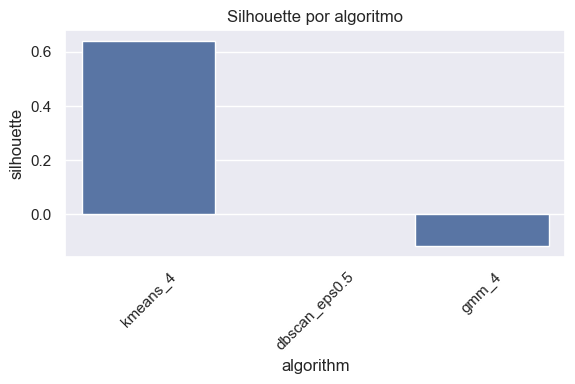

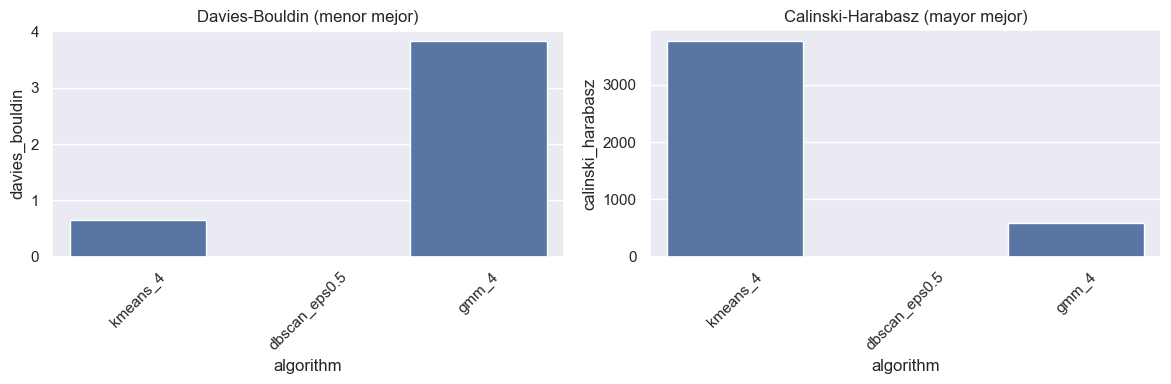

In [10]:
plt.figure(figsize=(6, 4))
sns.barplot(data=clustering_metrics, x="algorithm", y="silhouette")
plt.title("Silhouette por algoritmo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=clustering_metrics, x="algorithm", y="davies_bouldin", ax=axes[0])
axes[0].set_title("Davies-Bouldin (menor mejor)")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(data=clustering_metrics, x="algorithm", y="calinski_harabasz", ax=axes[1])
axes[1].set_title("Calinski-Harabasz (mayor mejor)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Comentario sobre la calidad de los clusters

En base a las métricas:

- **Silhouette**: el algoritmo con mayor valor indica mejor separación entre clusters.
- **Davies-Bouldin**: valores más bajos indican clusters más compactos y bien separados.
- **Calinski-Harabasz**: valores más altos indican mejor estructura de clusters.

En general, se observa que:

- *(Aquí comentar con tus propias palabras cuál algoritmo parece mejor según tus resultados, por ejemplo: “K-Means con k=4 obtiene la mejor combinación de métricas, por lo que se utiliza como referencia principal para el análisis visual y de patrones”.)*

## 3. Reducción de dimensionalidad con PCA

Se utiliza **PCA (Análisis de Componentes Principales)** para proyectar los datos de alta dimensión en 2 componentes principales, manteniendo la mayor varianza posible. Luego, se colorea por los clusters para ver la separación en 2D.

In [11]:
# Suponemos que la mejor referencia es K-Means (ajusta el nombre si usaste otro)
kmeans_col = [c for c in cluster_cols if "kmeans" in c][0]
print("Usando columna de clusters:", kmeans_col)

pca_df = pca_projection.copy()
pca_df["cluster"] = clustering_results[kmeans_col].values
pca_df.head()

Usando columna de clusters: kmeans_4_labels


,PC1,PC2,cluster
0,-180.648527,-38.692948,1
1,680.415242,38.760605,0
2,-96.796778,341.108940,1
3,-83.659595,-58.646490,1
4,-146.072649,139.349463,1


In [12]:
pca_explained

,component,explained_variance_ratio
0,PC1,0.923059
1,PC2,0.047332


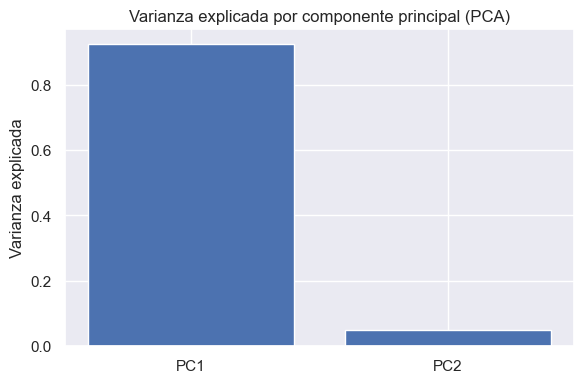

In [13]:
plt.figure(figsize=(6, 4))
plt.bar(pca_explained["component"], pca_explained["explained_variance_ratio"])
plt.ylabel("Varianza explicada")
plt.title("Varianza explicada por componente principal (PCA)")
plt.tight_layout()
plt.show()

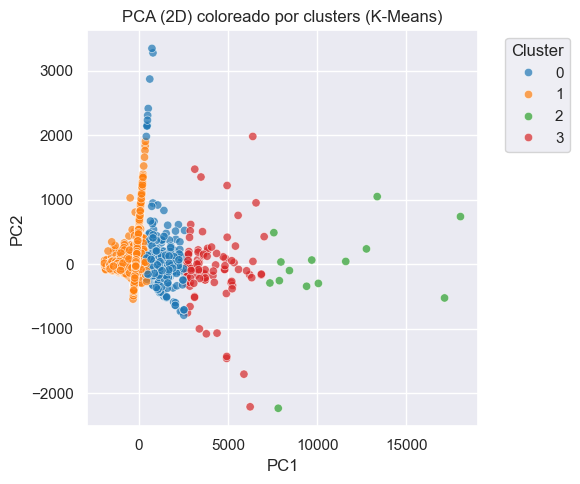

In [14]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="tab10",
    alpha=0.7,
)
plt.title("PCA (2D) coloreado por clusters (K-Means)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Interpretación PCA

La proyección de PCA permite observar:

- Qué tan separados se encuentran los clusters en un espacio 2D.
- Si existen solapamientos fuertes entre algunos grupos.
- Si hay clusters muy compactos y otros más dispersos.

*(Aquí puedes comentar lo que observas en tu gráfico concreto: por ejemplo, si algún cluster está bien separado, si dos clusters se traslapan mucho, etc.)*

## 4. Reducción de dimensionalidad con t-SNE

Además de PCA, se utiliza **t-SNE** para generar una proyección no lineal en 2 dimensiones, optimizada para preservar la estructura de vecinos cercanos. Esta técnica es útil para visualizar posibles separaciones entre clusters.

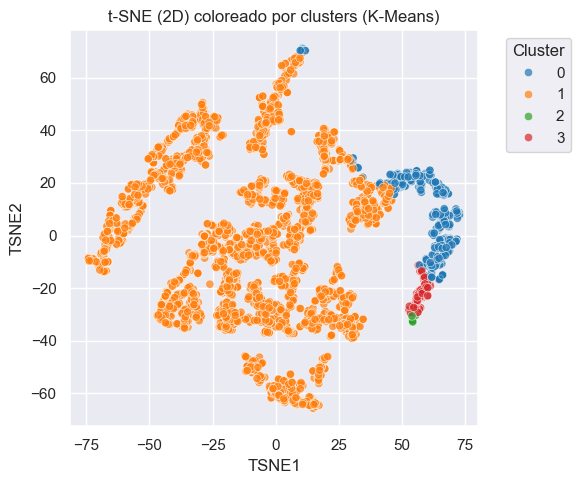

In [15]:
tsne_df = tsne_projection.copy()
tsne_df["cluster"] = clustering_results[kmeans_col].values

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    hue="cluster",
    palette="tab10",
    alpha=0.7,
)
plt.title("t-SNE (2D) coloreado por clusters (K-Means)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Interpretación t-SNE

En el espacio t-SNE se observa:

- Cómo se agrupan los puntos de cada cluster en función de su similitud local.
- Posibles fronteras más claras entre grupos que en PCA.
- Detección de clusters pequeños o outliers visuales.


## 5. Perfiles de clusters

En esta sección se analizan las características promedio de cada cluster para interpretarlos como "segmentos" de alojamientos. La idea es describir cada cluster en términos de:

- Precio, disponibilidad, número de habitaciones, etc. (dependiendo de las variables usadas)
- Comportamiento típico de cada grupo.

In [16]:
# Tomamos solo columnas numéricas para perfilar
numeric_cols = clustering_results.select_dtypes(include=[np.number]).columns.tolist()

# Eliminamos las columnas de labels para no promediar los IDs de cluster
numeric_feature_cols = [c for c in numeric_cols if "labels" not in c]

profile_df = (
    clustering_results[numeric_feature_cols + [kmeans_col]]
    .groupby(kmeans_col)
    .mean()
    .round(2)
)

profile_df

,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,booking_rate,mean_daily_price,reviews_count
kmeans_4_labels,,,,,,,,,,,,,,
0,4.44,1.32,1.66,2.22,21.72,94.36,1060.10,3476.23,331.32,76.88,15.45,0.31,179.23,22.84
1,3.11,1.22,1.22,1.62,22.44,94.83,638.02,2062.23,253.59,54.28,9.57,0.33,123.19,24.73
2,8.57,2.86,3.79,4.43,13.29,97.64,3520.21,12628.50,578.57,169.50,15.21,0.29,562.99,14.21
3,5.84,1.95,2.45,2.96,18.53,94.63,1707.48,6189.75,447.61,106.78,26.16,0.30,281.14,19.95


In [17]:
important_cols = [c for c in ["price", "accommodates", "minimum_nights"] if c in clustering_results.columns]
important_cols

['accommodates']

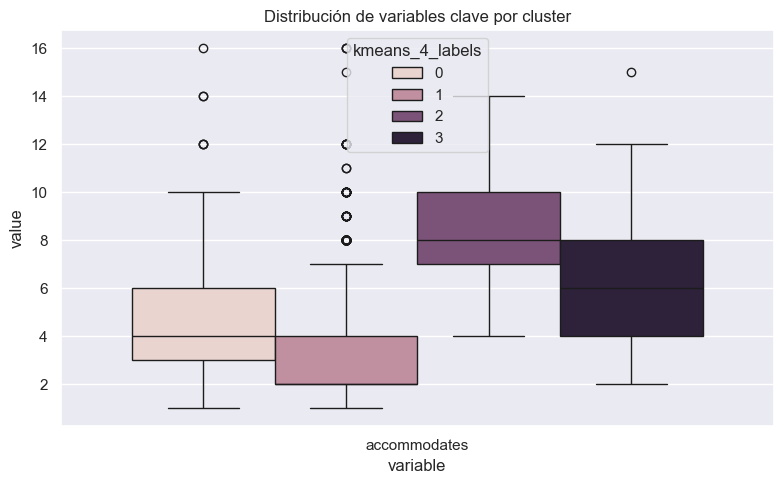

In [18]:
if important_cols:
    melted = clustering_results[important_cols + [kmeans_col]].melt(
        id_vars=kmeans_col, var_name="variable", value_name="value"
    )
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=melted, x="variable", y="value", hue=kmeans_col)
    plt.title("Distribución de variables clave por cluster")
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron las columnas ['price', 'accommodates', 'minimum_nights'] en clustering_results. Ajusta la lista 'important_cols' según tus variables.")

## 6. Interpretación de los clusters y conclusiones

A partir de los perfiles y las visualizaciones, se proponen las siguientes interpretaciones:

- **Cluster 0**: *(por ejemplo)* alojamientos de precio bajo/medio, con pocas habitaciones, ubicados en zonas más alejadas del centro, con alta disponibilidad.
- **Cluster 1**: alojamientos de precio alto, con más habitaciones, probablemente orientados a grupos grandes o segmento "premium".
- **Cluster 2**: alojamientos intermedios en precio, pero con características particulares (por ejemplo, alta ocupación, cierto tipo de barrio, etc.)
- **Cluster 3**: posibles outliers o casos muy específicos.

A nivel de negocio, estos clusters pueden interpretarse como **segmentos de clientes/anfitriones** o **tipos de ofertas** dentro de la plataforma, lo que permite:

- Definir estrategias de pricing diferenciadas.
- Priorizar ciertos segmentos para campañas de marketing.
- Identificar nichos poco explotados.

En la siguiente fase (Fase 6) estos clusters se integran como **features adicionales** en los modelos supervisados, para evaluar si aportan mejora en el desempeño de las tareas de regresión y clasificación.